1. Loading and preparing data...

2. Loading traces and recomputing log-likelihoods...
   Loaded trace for M_base. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

   Loaded trace for M_S. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

   Loaded trace for M_C. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

   Loaded trace for M_R. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

   Loaded trace for M_SC. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

   Loaded trace for M_SR. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

   Loaded trace for M_CR. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

   Loaded trace for M_SCR. Recomputing log-likelihood...


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


3. Performing LOO model comparison... (This may take a few minutes)


C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\drfox\anaconda3\envs\lba_env\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(



--- Model Comparison Results (Lower LOO is better) ---
        rank     elpd_loo      p_loo   elpd_diff        weight         se  \
M_SC       0 -7125.696477  45.786231    0.000000  1.000000e+00  24.084415   
M_SCR      1 -7131.655416  46.216610    5.958939  6.080313e-09  24.120967   
M_S        2 -7143.979979  43.969321   18.283502  5.616585e-09  23.509494   
M_SR       3 -7149.869499  44.375875   24.173021  5.516085e-09  23.527527   
M_C        4 -7465.217619  25.737641  339.521141  2.504201e-10  16.312243   
M_CR       5 -7471.314553  25.868868  345.618076  1.542357e-10  16.309482   
M_base     6 -7477.249210  21.466081  351.552733  9.259171e-11  16.594254   
M_R        7 -7482.814370  21.519951  357.117893  0.000000e+00  16.580585   

              dse  warning scale  
M_SC     0.000000    False   log  
M_SCR    0.237356    False   log  
M_S      3.710341    False   log  
M_SR     3.661534    False   log  
M_C     21.538982     True   log  
M_CR    21.524186     True   log  
M_bas

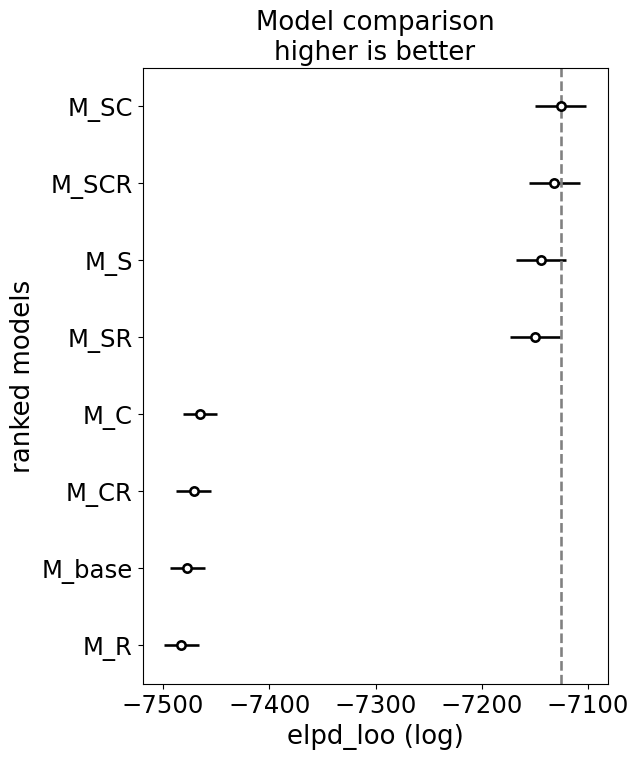


=== Model Comparison Complete ===


In [2]:
# =============================================================================
# Formal Comparison of the LBA Power Set Models
#
# Description:
# This script performs a formal Bayesian model comparison on the 8 LBA models
# fit by the `fit_lba_power_set.py` script. It uses the ArviZ library to
# calculate the Leave-One-Out cross-validation (LOO) metric for each model.
#
# This version recomputes the log-likelihood for each model after loading
# to ensure numerical stability and avoid errors during comparison. It uses
# the modern pm.CustomDist API for defining the likelihood.
# =============================================================================

# --- 1. Import Necessary Libraries ---
import arviz as az
import os
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as pt
import numpy as np

# --- 2. Custom Log-Likelihood and Model Building Functions ---

# The logp function signature is updated for pm.CustomDist.
# The observed data (`value`) is now the first argument.
def logp(value, v_alc, v_soc, k_alc, k_soc, A, tau):
    """
    Custom LBA log-likelihood function for PyMC's CustomDist.
    Calculates the pointwise log-likelihood for each trial.
    """
    # CORRECTED: Access rt and choice via indexing, not unpacking.
    # `value` is a single symbolic tensor with shape (2, n_trials).
    rt = value[0]
    choice = value[1]

    epsilon = 1e-8
    s = 1.0
    b_alc = A + k_alc
    b_soc = A + k_soc
    t0 = tau
    t = rt - t0
    v_alc = pt.maximum(v_alc, epsilon)
    v_soc = pt.maximum(v_soc, epsilon)
    b_alc = pt.maximum(b_alc, epsilon)
    b_soc = pt.maximum(b_soc, epsilon)
    A = pt.maximum(A, epsilon)
    t_safe = pt.maximum(t, epsilon)
    term1_alc = (b_alc - A - t_safe * v_alc) / (t_safe * s)
    term2_alc = (b_alc - t_safe * v_alc) / (t_safe * s)
    pdf_alc = (v_alc * pt.exp(pm.logp(pm.Normal.dist(0, 1), term1_alc)) -
               (b_alc - A) / t_safe * pt.exp(pm.logp(pm.Normal.dist(0, 1), term2_alc)))
    cdf_alc = 1 + ((b_alc - A - t_safe * v_alc) / A * pt.exp(pm.logp(pm.Normal.dist(0, 1), term1_alc)) -
                   (b_alc - t_safe * v_alc) / A * pt.exp(pm.logp(pm.Normal.dist(0, 1), term2_alc)))
    term1_soc = (b_soc - A - t_safe * v_soc) / (t_safe * s)
    term2_soc = (b_soc - t_safe * v_soc) / (t_safe * s)
    pdf_soc = (v_soc * pt.exp(pm.logp(pm.Normal.dist(0, 1), term1_soc)) -
               (b_soc - A) / t_safe * pt.exp(pm.logp(pm.Normal.dist(0, 1), term2_soc)))
    cdf_soc = 1 + ((b_soc - A - t_safe * v_soc) / A * pt.exp(pm.logp(pm.Normal.dist(0, 1), term1_soc)) -
                   (b_soc - t_safe * v_soc) / A * pt.exp(pm.logp(pm.Normal.dist(0, 1), term2_soc)))
    
    log_likelihood = pt.switch(
        pt.eq(choice, 0),
        pt.log(pt.maximum(pdf_alc, epsilon)) + pt.log(pt.maximum(1 - cdf_soc, epsilon)),
        pt.log(pt.maximum(pdf_soc, epsilon)) + pt.log(pt.maximum(1 - cdf_alc, epsilon))
    )
    
    return pt.switch(t < 0, -np.inf, log_likelihood)

def build_model(data, n_subjects, n_sessions, tau_upper, S=False, C=False, R=False, T=False):
    """
    Generalized function to build any of the 16 models. Must match the fitting script.
    """
    coords = {"subject_idx": np.arange(n_subjects), "session": ["early", "late", "pun"]}
    with pm.Model(coords=coords) as model:
        v_alc_group_mu = pm.Normal('v_alc_group_mu', mu=1, sigma=1, dims="session" if S else None)
        v_soc_group_mu = pm.Normal('v_soc_group_mu', mu=1, sigma=1, dims="session" if S else None)
        A_group_mu_log = pm.Normal('A_group_mu_log', mu=-1, sigma=1, dims="session" if C else None)
        k_group_mu_log = pm.Normal('k_group_mu_log', mu=-1, sigma=1, dims="session" if R else None)
        tau_group_mu_log = pm.Normal('tau_group_mu_log', mu=-1, sigma=1, dims="session" if T else None)
        v_alc_group_sigma = pm.HalfNormal('v_alc_group_sigma', sigma=1)
        v_soc_group_sigma = pm.HalfNormal('v_soc_group_sigma', sigma=1)
        A_group_sigma = pm.HalfNormal('A_group_sigma', sigma=0.5)
        k_group_sigma = pm.HalfNormal('k_group_sigma', sigma=0.5)
        tau_group_sigma = pm.HalfNormal('tau_group_sigma', sigma=0.1)
        v_alc_offset = pm.Normal('v_alc_offset', mu=0, sigma=1, dims=("subject_idx", "session") if S else "subject_idx")
        v_soc_offset = pm.Normal('v_soc_offset', mu=0, sigma=1, dims=("subject_idx", "session") if S else "subject_idx")
        A_offset = pm.Normal('A_offset', mu=0, sigma=1, dims=("subject_idx", "session") if C else "subject_idx")
        k_offset = pm.Normal('k_offset', mu=0, sigma=1, dims=("subject_idx", "session") if R else "subject_idx")
        tau_offset = pm.Normal('tau_offset', mu=0, sigma=1, dims=("subject_idx", "session") if T else "subject_idx")
        v_alc = pm.Deterministic('v_alcohol', v_alc_group_mu + v_alc_offset * v_alc_group_sigma, dims=("subject_idx", "session") if S else "subject_idx")
        v_soc = pm.Deterministic('v_social', v_soc_group_mu + v_soc_offset * v_soc_group_sigma, dims=("subject_idx", "session") if S else "subject_idx")
        A = pm.Deterministic('A', pm.math.exp(A_group_mu_log + A_offset * A_group_sigma), dims=("subject_idx", "session") if C else "subject_idx")
        k = pm.Deterministic('k', pm.math.exp(k_group_mu_log + k_offset * k_group_sigma), dims=("subject_idx", "session") if R else "subject_idx")
        tau_unbounded = pm.math.exp(tau_group_mu_log + tau_offset * tau_group_sigma)
        tau = pm.Deterministic('tau', pm.math.minimum(tau_unbounded, tau_upper), dims=("subject_idx", "session") if T else "subject_idx")
        
        pm.CustomDist(
            'likelihood',
            v_alc[data['subj_idx_code'].values, data['session_code'].values] if S else v_alc[data['subj_idx_code'].values],
            v_soc[data['subj_idx_code'].values, data['session_code'].values] if S else v_soc[data['subj_idx_code'].values],
            k[data['subj_idx_code'].values, data['session_code'].values] if R else k[data['subj_idx_code'].values],
            k[data['subj_idx_code'].values, data['session_code'].values] if R else k[data['subj_idx_code'].values],
            A[data['subj_idx_code'].values, data['session_code'].values] if C else A[data['subj_idx_code'].values],
            tau[data['subj_idx_code'].values, data['session_code'].values] if T else tau[data['subj_idx_code'].values],
            logp=logp,
            observed=np.stack((data['rt'].values, data['response'].values), axis=0)
        )
    return model


# --- 3. Main Execution Block ---
def main():
    """
    Main function to load traces, perform comparison, and save results.
    """
    # --- Configuration ---
    data_file_path = r'C:\Users\drfox\LBA_Gemini\aIC_Choice.csv'
    results_dir = 'LBA_Model_Power_Set'
    output_dir = 'LBA_Model_Comparison_Results'
    os.makedirs(output_dir, exist_ok=True)
    
    # --- Data Preparation (needed for re-building models) ---
    print("1. Loading and preparing data...")
    all_data = pd.read_csv(data_file_path)
    all_data = all_data.dropna(subset=['rt', 'response'])
    all_data['response'] = all_data['response'].astype(int)
    all_data['subj_idx_code'] = pd.Categorical(all_data['subj_idx']).codes
    all_data['session_code'] = pd.Categorical(all_data['session_type'], categories=['early', 'late', 'pun'], ordered=True).codes
    n_subjects = all_data['subj_idx'].nunique()
    n_sessions = all_data['session_type'].nunique()
    tau_upper_limit = max(0.05, all_data['rt'].min() - 0.01)

        # --- UPDATED: Define the Full 16 Models of the Power Set ---
    models_to_process = {
        "M_base": {"S": False, "C": False, "R": False, "T": False},
        "M_S":    {"S": True,  "C": False, "R": False, "T": False},
        "M_C":    {"S": False, "C": True,  "R": False, "T": False},
        "M_R":    {"S": False, "C": False, "R": True,  "T": False},
        #"M_T":    {"S": False, "C": False, "R": False, "T": True},
        "M_SC":   {"S": True,  "C": True,  "R": False, "T": False},
        "M_SR":   {"S": True,  "C": False, "R": True,  "T": False},
        #"M_ST":   {"S": True,  "C": False, "R": False, "T": True},
        "M_CR":   {"S": False, "C": True,  "R": True,  "T": False},
        #"M_CT":   {"S": False, "C": True,  "R": False, "T": True},
        #"M_RT":   {"S": False, "C": False, "R": True,  "T": True},
        "M_SCR":  {"S": True,  "C": True,  "R": True,  "T": False},
        #"M_SCT":  {"S": True,  "C": True,  "R": False, "T": True},
        #"M_SRT":  {"S": True,  "C": False, "R": True,  "T": True},
        #"M_CRT":  {"S": False, "C": True,  "R": True,  "T": True},
        #"M_SCRT": {"S": True,  "C": True,  "R": True,  "T": True},
    }

    # --- Load Traces and Recompute Log-Likelihood ---
    print("\n2. Loading traces and recomputing log-likelihoods...")
    traces_to_compare = {}
    for name, params in models_to_process.items():
        trace_path = os.path.join(results_dir, f'trace_{name}.nc')
        if os.path.exists(trace_path):
            try:
                trace = az.from_netcdf(trace_path)
                print(f"   Loaded trace for {name}. Recomputing log-likelihood...")
                model = build_model(all_data, n_subjects, n_sessions, tau_upper_limit, **params)
                with model:
                    pm.compute_log_likelihood(trace, extend_inferencedata=True)
                traces_to_compare[name] = trace
            except Exception as e:
                print(f"❌ ERROR processing trace for {name}: {e}")
        else:
            print(f"⚠️ WARNING: Trace file not found for {name}. It will be excluded.")

    if len(traces_to_compare) < 2:
        print("\nNot enough valid models were found to perform a comparison.")
        return

    # --- Perform Model Comparison ---
    print("\n3. Performing LOO model comparison... (This may take a few minutes)")
    comparison_df = az.compare(traces_to_compare)

    print("\n--- Model Comparison Results (Lower LOO is better) ---")
    print(comparison_df)

    # --- Save Results ---
    print("\n4. Saving comparison results...")
    csv_path = os.path.join(output_dir, 'model_comparison_loo.csv')
    comparison_df.to_csv(csv_path)
    print(f"   Comparison table saved to: {csv_path}")

    # Generate and save the comparison plot
    try:
        az.plot_compare(comparison_df)
        plot_path = os.path.join(output_dir, 'model_comparison_plot.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"   Comparison plot saved to: {plot_path}")
        plt.show()
    except Exception as e:
        print(f"   ERROR generating comparison plot: {e}")

    print("\n=== Model Comparison Complete ===")

if __name__ == '__main__':
    main()

